In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Dataset Proprocessing

## Loading Dataset

In [2]:
dataset = [['Skirt', 'Sneakers', 'Scarf', 'Pants', 'Hat'],
        ['Sunglasses', 'Skirt', 'Sneakers', 'Pants', 'Hat'],
        ['Dress', 'Sandals', 'Scarf', 'Pants', 'Heels'],
        ['Dress', 'Necklace', 'Earrings', 'Scarf', 'Hat', 'Heels', 'Hat'],
        ['Earrings', 'Skirt', 'Skirt', 'Scarf', 'Shirt', 'Pants']]

In [3]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset) # applying one-hot-encoding : numpy array
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,Dress,Earrings,Hat,Heels,Necklace,Pants,Sandals,Scarf,Shirt,Skirt,Sneakers,Sunglasses
0,False,False,True,False,False,True,False,True,False,True,True,False
1,False,False,True,False,False,True,False,False,False,True,True,True
2,True,False,False,True,False,True,True,True,False,False,False,False
3,True,True,True,True,True,False,False,True,False,False,False,False
4,False,True,False,False,False,True,False,True,True,True,False,False


## Visualization

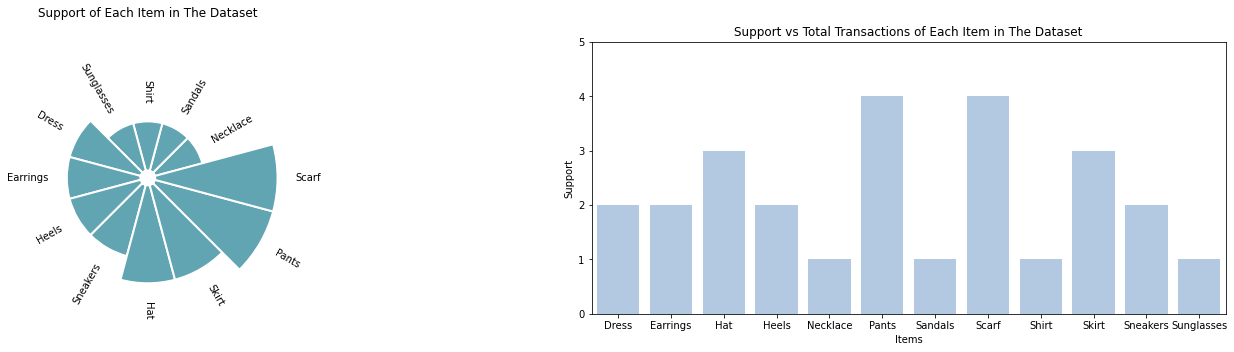

In [4]:
# Build a dataset
df2 = pd.DataFrame({
    "Name": df.sum().index,
    "Value": df.sum().values
    })

df2.sort_values(by="Value", inplace=True)
# set figure size
plt.figure(figsize=(25,5))

# plot polar axis
ax = plt.subplot(121, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30
# Compute min and min in the dataset
min = df2.Value.min()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The minimum will be converted to the upperLimit (100)
slope = (upperLimit - min) / min
heights = slope * df2.Value + upperLimit
# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df2.index)
# Compute the angle each bar is centered on:
indexes = list(range(1, len(df2.index)+1))
angles = [element * width for element in indexes]

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)


# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df2.Name):

    # Labels are rotated. Rotation must be specified in degrees
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=upperLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")
        
plt.title("Support of Each Item in The Dataset")

ax2 = plt.subplot(122)
sns.barplot(x=df.columns, y=df.sum(), color="#abc9ea", ax=ax2)
plt.ylim(0, df.shape[0])
plt.xlabel("Items")
plt.ylabel("Support")
plt.title("Support vs Total Transactions of Each Item in The Dataset")
plt.show()

We notice that *Pants* and *Scarfs* are the most frequently bought items, *Skirts* and *Hats* come in second, and the least bought items are *Sandals*, *Sunglasses*, *Necklaces* and *Shirts*.

# 2. Finding New Marketing Plans

## Apriori Algorithm

In [5]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules 
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.6,(Hat)
1,0.8,(Pants)
2,0.8,(Scarf)
3,0.6,(Skirt)
4,0.6,"(Pants, Scarf)"
5,0.6,"(Skirt, Pants)"


In [6]:
association_rules(frequent_itemsets,metric="lift",min_threshold=1.20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Skirt),(Pants),0.6,0.8,0.6,1.00,1.25,0.12,inf
1,(Pants),(Skirt),0.8,0.6,0.6,0.75,1.25,0.12,1.6


The above table contains the <u>*Association Rules*</u> with *confidence >= 70%* and *lift >= 1.20.*

# Market Basket Optimisation

## Loading dataset as numpy array + removing insignificant transactions

In [7]:
import csv

with open('Market_Basket_Optimisation.csv') as file_CSV:
    basket_transactions = list(csv.reader(file_CSV))

# Removing unsignificant transaction: accepting transactions with at least two items in the basket    
basket_transactions2 = []
for row in basket_transactions:
    if len(row) >= 2:
        basket_transactions2.append(row)

len(basket_transactions2), len(basket_transactions)

(5747, 7501)

## One-hot-encoding the dataset

In [8]:
te = TransactionEncoder()
te_ary = te.fit(basket_transactions2).transform(basket_transactions2) # applying one-hot-encoding : numpy array
basket = pd.DataFrame(te_ary, columns=te.columns_)
basket.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


## Plot

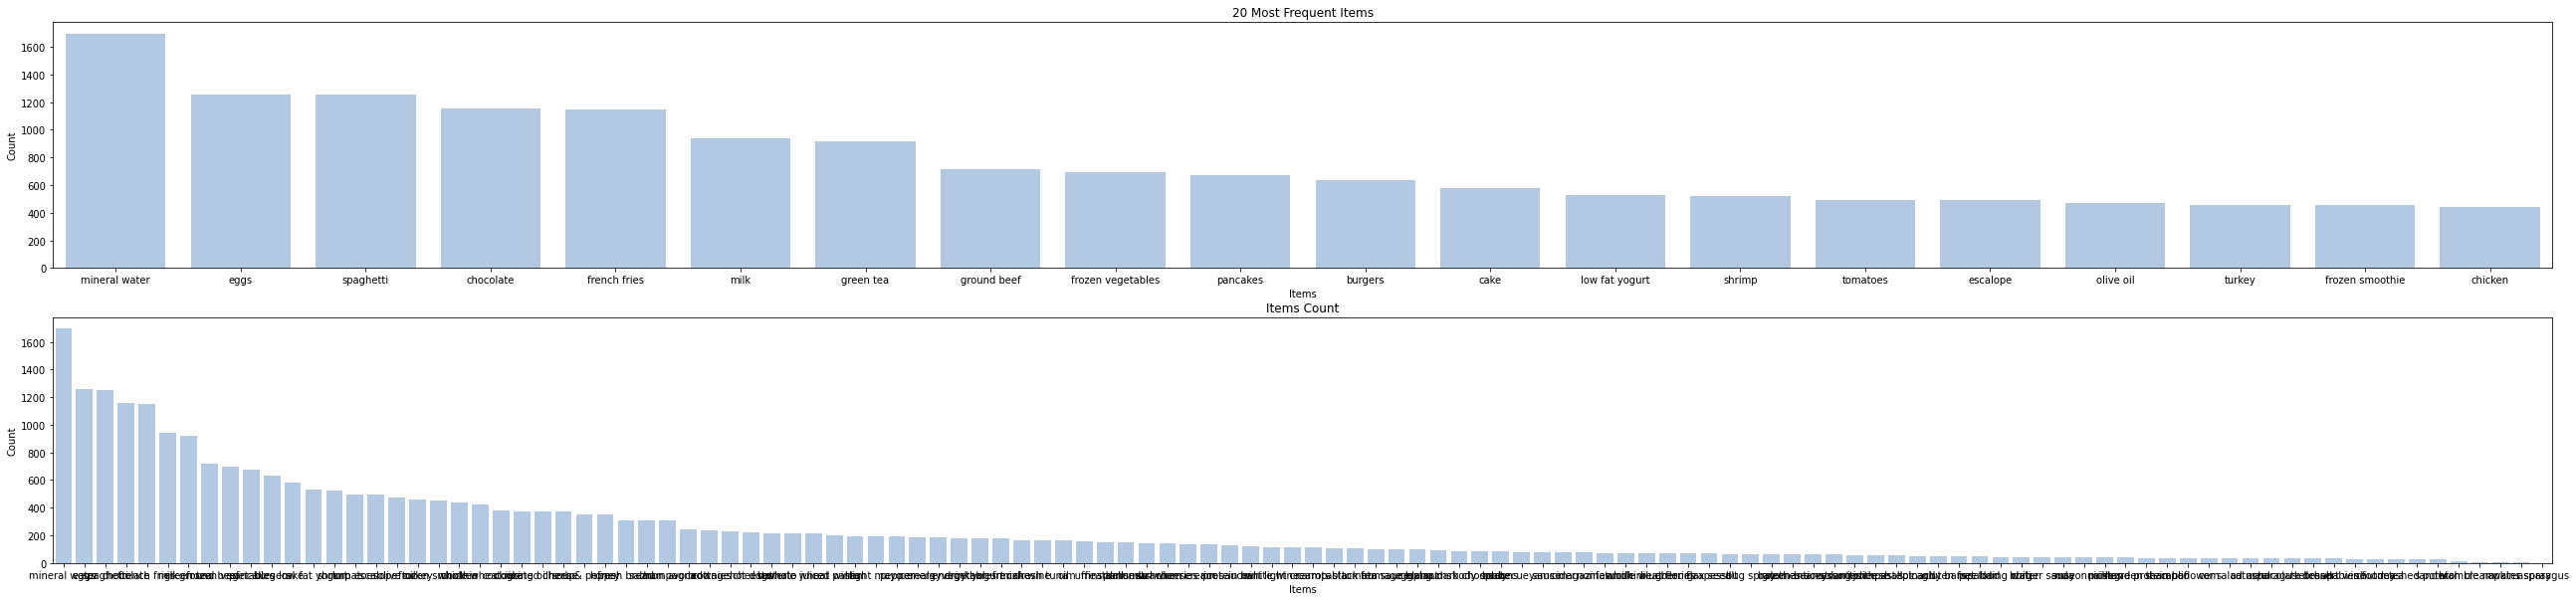

In [9]:
plt.figure(figsize=[45, 10])
ax2 = plt.subplot(211)
basket_sorted = basket.sum().sort_values(ascending=False)
sns.barplot(x=basket_sorted.index[: 20], y=basket_sorted.values[:20], color="#abc9ea", ax=ax2)
plt.xlabel("Items")
plt.ylabel("Count")
plt.title("20 Most Frequent Items")

ax3 = plt.subplot(212)
sns.barplot(x=basket_sorted.index, y=basket_sorted.values, color="#abc9ea", ax=ax3)
plt.xlabel("Items")
plt.ylabel("Count")
plt.title("Items Count")

plt.show()

## Applying Apriori: Extracting Association Rules

In [10]:
basket_frequent_itemsets = apriori(basket, min_support=0.0050, use_colnames=True)
res = association_rules(basket_frequent_itemsets, metric="lift",min_threshold=3).sort_values(by="confidence", ascending=False)
res = res[res.confidence >= 0.2]
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
18,"(soup, frozen vegetables)",(milk),0.010440,0.163390,0.005220,0.500000,3.060170,0.003514,1.673221
14,"(herb & pepper, chocolate)",(ground beef),0.011832,0.124587,0.005220,0.441176,3.541119,0.003746,1.566529
4,(pasta),(escalope),0.018792,0.085958,0.007656,0.407407,4.739616,0.006041,1.542446
26,"(mineral water, whole wheat pasta)",(olive oil),0.012528,0.081956,0.005046,0.402778,4.914573,0.004019,1.537190
22,"(herb & pepper, spaghetti)",(ground beef),0.021228,0.124587,0.008352,0.393443,3.157982,0.005707,1.443249
20,"(herb & pepper, mineral water)",(ground beef),0.022272,0.124587,0.008700,0.390625,3.135366,0.005925,1.436576
9,(tomato sauce),(ground beef),0.017922,0.124587,0.006960,0.388350,3.117101,0.004727,1.431231
12,(pasta),(shrimp),0.018792,0.090830,0.006612,0.351852,3.873741,0.004905,1.402719
3,(mushroom cream sauce),(escalope),0.024013,0.085958,0.007482,0.311594,3.624963,0.005418,1.327766
1,(light cream),(chicken),0.020010,0.076562,0.005916,0.295652,3.861621,0.004384,1.311054


Now that we extracted the association rules and sorted them by confidence, we can drastically increase sales of this shop.
